In [1]:
%matplotlib inline

import json
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import util
from skimage import io
from skimage import exposure
from skimage import morphology
from skimage import measure
from skimage import filters
from skimage import registration
from skimage import transform
from skimage import color
from skimage import feature
from sklearn import metrics

# Drawing functions use (row, cols) coords, transformation functions use (x, y) coords

PATH='../spotGEO/'

def read_annotation_file(path):
    '''This creates a dictionary where the first key is the sequence id,
    and the second key is the frame id, which contains a list of the 
    annotation points as lists of floating numbers.
    For example sequence #1 shown above contains 3 objects, which are visible in both frames #1 and #3.'''
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict


def get_sequence(seqid):
    frames = [util.img_as_float(io.imread(f"../spotGEO/train/{seqid}/{i+1}.png", as_gray=True)) for i in range(0, 5)]
    frames = np.array(frames)
    return frames


def get_targets(seqid):
    '''Returns array of n_objects x n_frames x coords'''
    return np.array([dataset[seqid][frame] for frame in dataset[seqid]]).swapaxes(0, 1)


def draw_circle(ax, r, c, radius, color):
    circle = plt.Circle((c, r), radius, color=color, fill=False)
    ax.add_artist(circle)

    
def draw_target(ax, r, c):
    draw_circle(ax, r, c, radius=10, color='r')
    
    
def draw_prediction(ax, r, c):
    draw_circle(ax, r, c, radius=10, color='g')
    
    
def extract_region(arr, r0, c0, radius):
    """ Returns the values within a radius of the given x, y coordinates """
    return arr[(r0 - radius) : (r0 + radius + 1), (c0 - radius) : (c0 + radius + 1)]


def filter_valid_regions(regions):
    return [region for region in regions if region.shape[0] == region.shape[1]]

def filter_valid(regions, coords):
    isel = [region.shape[0] == region.shape[1] and region.shape[0] != 0 for region in regions]

    regions = [regions[i] for i, cond in enumerate(isel) if cond]
    coords = coords[isel]    
    
    return regions, coords

def register(src, dst):
    shifts, _, _ = registration.phase_cross_correlation(src, dst, upsample_factor=100)
    # phase_cross_correlation returns y, x numpy coords, we flip it to x, y
    return transform.SimilarityTransform(translation=np.flip(shifts))


def evaluate_transform_matrix(frames):
    T1 = register(frames[1], frames[0])
    T2 = register(frames[2], frames[1])
    T3 = register(frames[3], frames[2])
    T4 = register(frames[4], frames[3])

    # Sometimes the transformation matrix may return outlier transformations
    # here we assume the same transformation matrix repeated for all the frames
    Q = np.array([T.params.ravel() for T in [T1, T2, T3, T4]])

    T = np.median(Q, axis=0).reshape(3,3)
    return T


def evaluate_transforms_to_frame2(frames):
    T = evaluate_transform_matrix(frames)
    return [T @ T, T, np.eye(3), np.linalg.inv(T), np.linalg.inv(T @ T)]


def transform_sequence_to_frame2(frames):
    Ts = evaluate_transforms_to_frame2(frames)
    return np.array([warp(frame, Ti) for Ti, frame in zip(Ts, frames)])


def warp(frame, T):
    return transform.warp(frame, np.linalg.inv(T))


def get_proposal(registered, frameid):
    Ibase = np.max(registered[np.arange(len(registered)) != frameid], axis=0)

    mask = (registered[frameid] > 0)
    Idiff = np.maximum((registered[frameid]*mask) - (Ibase), 0)
    
    # Find local maxima as x, y coords
    Imaxima = morphology.h_maxima(Idiff, 0.02, selem=morphology.diamond(5))    
    r, c = np.where(Imaxima > 0)
    coords = np.c_[c, r]

    return coords


def find_targets(arr, targets):
    ''' Find regions indices corresponding to target '''
    d = metrics.pairwise_distances(arr, targets)
    return np.argmin(d, axis=0)


def coords_from_binary(arr):
    r, c = np.where(Imask > 0)
    return np.c_[c, r]


def remove_stars(registered, coords):
    ''' Remove stars and recompute coordinates '''
    Ifull = np.max(registered, axis=0)

    Imaxima = np.zeros(Ifull.shape, dtype='bool')
    Imaxima[coords[:, 1], coords[:, 0]] = 1.0

    Imask = Imaxima * (Ifull < 0.6)
    
    coords = coords_from_binary(Imask > 0)
    
    return coords

Dataset contains 1280 elements
Targets 8


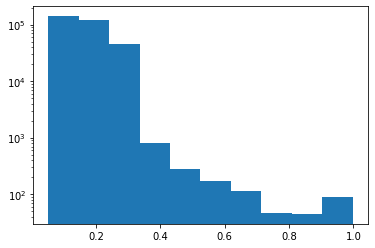

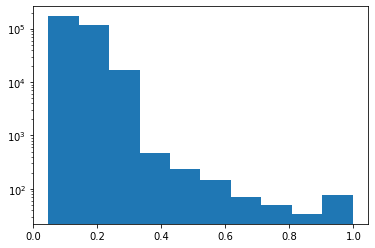

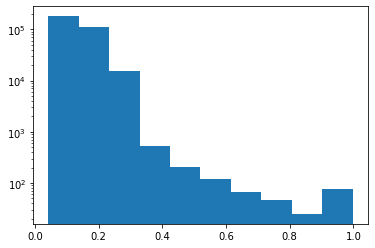

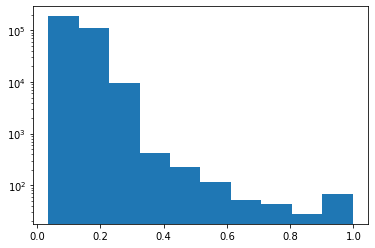

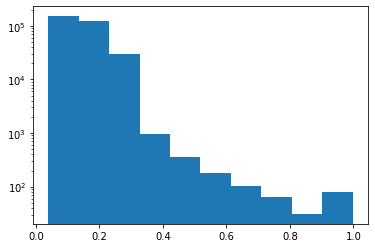

(5, 480, 640)
(8, 5, 2)


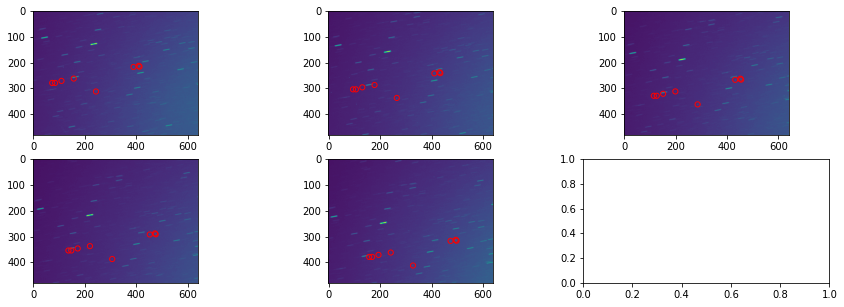

In [98]:
dataset = read_annotation_file(os.path.join(PATH, 'train_anno.json'))

print('Dataset contains', len(dataset), 'elements')

seqid = 72

frames = get_sequence(seqid)
targets = get_targets(seqid)

print('Targets', len(targets))

frames = exposure.adjust_sigmoid(frames, cutoff=0.4)

for frame in frames:
    plt.hist(frame.ravel(), log=True)
    plt.show()


print(frames.shape)
print(targets.shape)

fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()

for frameid in range(0,5):
    axs[frameid].imshow(frames[frameid], vmin=0, vmax=1)    
    for target in targets[:,frameid]:
        draw_target(axs[frameid], target[1], target[0])    
plt.show()


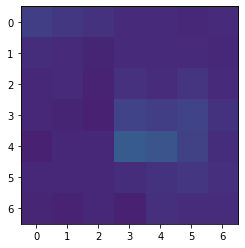

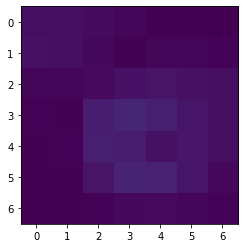

In [99]:
# Extract region centered at r0, c0

if len(targets) > 0:
    tid = 0
    frameid = 4

    r0, c0 = int(targets[tid,frameid,1]), int(targets[tid,frameid,0])

    Iregion = extract_region(frames[frameid], r0, c0, 3)

    plt.imshow(Iregion, vmin=0, vmax=1)
    plt.show()

    Ilaplace = filters.sobel(Iregion)

    plt.imshow(Ilaplace, vmin=0, vmax=1)
    plt.show()

(5, 480, 640)


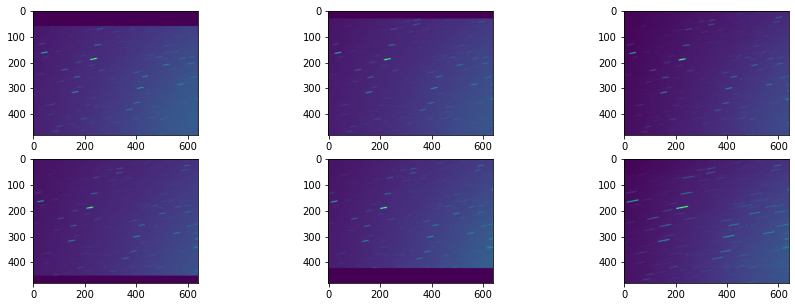

In [100]:
# Registration of frames to reference frame

registered = transform_sequence_to_frame2(frames)

print(registered.shape)

fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()

for i, frame in enumerate(registered):
    axs[i].imshow(frame)
    
axs[i+1].imshow(np.max(registered, axis=0))

plt.show()

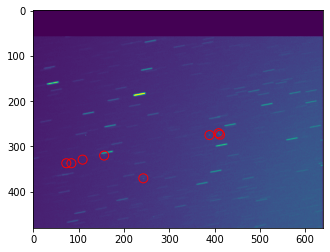

In [101]:
# Forward transform target to reference frame

Ts = evaluate_transforms_to_frame2(frames)

frameid = 0

plt.imshow(registered[frameid])

if len(targets) > 0:
    Z = transform.matrix_transform(targets[:, frameid], Ts[frameid])
    for z in Z:
        draw_target(plt.gcf().gca(), z[1], z[0])
        
plt.show()

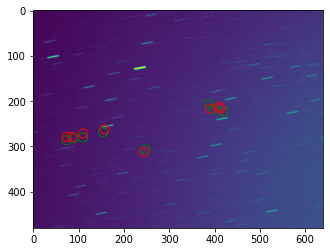

In [102]:
# Backward transform to original frame

plt.imshow(frames[frameid])
if len(targets) > 0:
    Z_pred = Z + np.random.normal(size=Z.shape, scale=5)
    object_pred = transform.matrix_transform(Z_pred, np.linalg.inv(Ts[frameid]))

    for o in object_pred:
        draw_prediction(plt.gcf().gca(), o[1], o[0])
    
    for t in targets[:, frameid]:
         draw_target(plt.gcf().gca(), t[1], t[0])
plt.show()

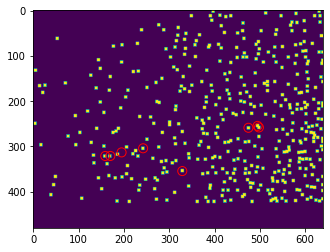

In [103]:
%matplotlib inline

frameid = 4

coords = get_proposal(registered, frameid)

Imaxima = np.zeros((480, 640))
Imaxima[coords[:, 1], coords[:, 0]] = 1.0

plt.imshow( morphology.dilation(Imaxima, selem=morphology.square(7)) )

if len(targets) > 0:
    Z = transform.matrix_transform(targets[:, frameid], Ts[frameid])
    for z in Z:
        draw_target(plt.gcf().gca(), z[1], z[0])
plt.show()

In [104]:
# Define ground truth
if len(targets) > 0:
    coords_true = np.concatenate([transform.matrix_transform(targets[:, frameid], Ts[frameid]) for frameid in range(0, 5)])
else:
    coords_true = []

# Extract proposal coordinates
coords = np.concatenate([get_proposal(registered, frameid) for frameid in range(0, 5)])

print(coords.shape)

(1123, 2)


(1091, 2)


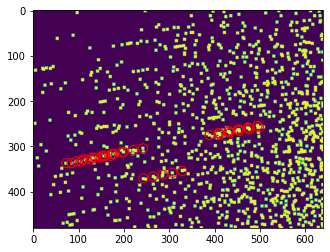

In [105]:
# Remove stars and recompute coordinates
Ifull = np.max(registered, axis=0)

Imaxima = np.zeros((480, 640), dtype='bool')

Imaxima[coords[:, 1], coords[:, 0]] = 1.0

Imask = Imaxima * (Ifull < 0.6)

r, c = np.where(Imask > 0)

coords = np.c_[c, r]

print(coords.shape)

plt.imshow( morphology.dilation(Imask, morphology.square(7)) )
for z in coords_true:
    draw_target(plt.gcf().gca(), z[1], z[0])
plt.show()

1047


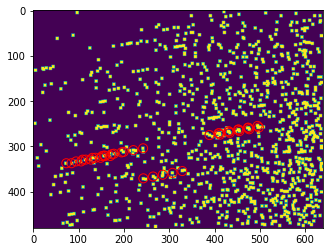

In [ ]:
# Remove invalid coordinates

Ifull = np.max(registered, axis=0)

regions = [extract_region(Ifull, r0, c0, radius=3) for c0, r0 in coords]

regions, coords = filter_valid(regions, coords)

coords = np.array(coords)
regions = np.array(regions)

print(len(coords))

Iout = np.zeros(Ifull.shape)
Iout[coords[:, 1], coords[:, 0]] = 1.0

plt.imshow( morphology.dilation(Iout, morphology.square(7)) )
for z in coords_true:
    draw_target(plt.gcf().gca(), z[1], z[0])
plt.show()

In [ ]:
from scipy.stats import pearsonr

vr = regions.reshape(len(coords), -1)

print(vr.shape)

d = np.zeros((len(coords),len(coords)))

for i, template in enumerate(vr):
    for j, v in enumerate(vr):
        r, _ = pearsonr(v, template)
        d[i, j] = r

print(d.shape, d.min(), d.max())

Q = np.sum( (d > 0.7), axis=0)

plt.hist(Q, bins=30)
plt.show()

idxs = np.where( Q < 35 )[0]

print( 'found highly correlated regions', len(idxs), np.sort(idxs) )

# Find target coordinates
if len(targets) > 0:
    target_idxs = np.concatenate([find_targets(coords, transform.matrix_transform(targets[:, frameid], Ts[frameid])) for frameid in range(0, 5)])
    print( 'target idxs', len(target_idxs), np.sort(target_idxs) )


Iout = np.zeros((480, 640))
Iout[coords[idxs, 1], coords[idxs, 0]] = 1

plt.figure(figsize=(15,5))
plt.imshow( morphology.dilation(Iout, morphology.square(7)) )
for z in coords_true:
    draw_target(plt.gcf().gca(), z[1], z[0])
plt.show()

(1047, 49)


In [ ]:
# Prepare dataset
import uuid
imgid = uuid.uuid1()

print(str(imgid))

for i, idx in enumerate(idxs):
    Iregion = regions[idx]
    
    if idx in target_idxs:
        io.imsave(f'dataset/train/target/{str(imgid)}-{i}.bmp', util.img_as_ubyte(Iregion), check_contrast=False)
    else:
        io.imsave(f'dataset/train/none/{str(imgid)}-{i}.bmp', util.img_as_ubyte(Iregion), check_contrast=False)